In [1]:
import numpy as np
import pandas as pd
import math
import scipy
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from os import listdir
%matplotlib inline

In [2]:
#Constants
pi = math.pi
heV = 4.14e-15 #eV*s
c = 2.99792e8 #m/s
kbeV = 8.6173e-5 #eV/K
keV = 8.6173e-5 #eV/K
h = 6.626e-34
kb = 1.38065e-23
q = 1.60218e-19
k = 1.3806488e-23
T = 300

CellAreacm = 0.0453
CellArea = CellAreacm*10**-4 #m^2
Ps=100 #mW/cm^2

In [4]:
Directory = '../../data/JVdata/2018_9-14JV/2018_9-14-2JV/'
LName = 'Stoddard_2018_9-14-2JV_3_1_scan_2.liv1'
DName = 'Stoddard_2018_9-14-2JV_3_1_scan_2.liv1'

Ldata = pd.read_csv(Directory + LName, delimiter='\t', header=None)
idx_end = Ldata[Ldata.iloc[:,0] == 'Jsc:'].index[0]
Ldata = Ldata.iloc[:idx_end-1,:]
Ldata.iloc[:,0] = pd.to_numeric(Ldata.iloc[:,0])
Ldata.iloc[:,0]
Ldata = np.array(Ldata)

Ddata = pd.read_csv(Directory + DName, delimiter='\t', header=None)
idx_end = Ddata[Ddata.iloc[:,0] == 'Jsc:'].index[0]
Ddata = Ddata.iloc[:idx_end-1,:]
Ddata.iloc[:,0] = pd.to_numeric(Ddata.iloc[:,0])
Ddata.iloc[:,0]
Ddata = np.array(Ddata)

Ldata = np.insert(Ldata, 2, -Ldata[:,1], axis=1)
Ddata = np.insert(Ddata, 2, -Ddata[:,1], axis=1)

JVinterp = interp1d(Ldata[:,0], Ldata[:,2], kind='cubic', bounds_error=False, fill_value='extrapolate')

JscL = -JVinterp(0)
VocL = scipy.optimize.fsolve(JVinterp,.95*max(Ldata[:,0]))
PPV = scipy.optimize.fmin(lambda x: x*JVinterp(x),.8*VocL,disp=False)
PCE = -PPV*JVinterp(PPV)
FF = PCE/(JscL*VocL)*100

#Sort data by ascending V, so less confusing
Ldata = Ldata[Ldata[:,0].argsort()]
Ddata = Ddata[Ddata[:,0].argsort()]

jsc_idx1 = np.argmin(abs(Ldata[:,0]))
jsc_idx2 = np.argmin(abs(Ldata[:,0]-0.05*VocL))
voc_idx1 = np.argmin(abs(Ldata[:,0]-.95*VocL))
voc_idx2 = np.argmin(abs(Ldata[:,0]-VocL))

p1 = np.polyfit(Ldata[jsc_idx1:jsc_idx2,2],Ldata[jsc_idx1:jsc_idx2,1],1)
RshL = p1[0]
p2 = np.polyfit(Ldata[voc_idx1:voc_idx2,2],Ldata[voc_idx1:voc_idx2,1],1)
RsL = p2[0]


default_figsize = mpl.rcParamsDefault['figure.figsize']
mpl.rcParams['figure.figsize'] = [1.5*val for val in default_figsize]
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

mpl.rc('font', **font)
mpl.rc('axes', linewidth=3)

datas = [PCE, VocL, JscL, FF]
n_rows = len(datas)
rows = ['$PCE\ [\%]$', '$V_{OC}\ [V]$', '$J_{SC}\ [mA/cm^2]$', '$FF\ [\%]$']
cell_text = []
for row in range(n_rows):
    if row != 1:
        cell_text.append(['%1.1f' % datas[row]])
    else:
        cell_text.append(['%1.2f' % datas[row]])

plt.plot(Ldata[:,0],Ldata[:,2],Ddata[:,0],Ddata[:,2],linewidth=3.0)
plt.plot([0, 1.3], [0, 0], color='.5', linestyle='--', linewidth=2)
plt.xlabel('$Voltage\ [V]$')
plt.ylabel('$Current\ Density\ [mA/cm^2]$')
plt.ylim(-20,5)
plt.xlim(0,1.3)
plt.table(cellText = cell_text,rowLabels = rows,loc='bottom',bbox = [0.45, 0.5, 0.15, 0.4])
plt.tick_params(which='both', width=3,length=10)
#plt.figure(figsize=(300, 250), dpi= 80, facecolor='w', edgecolor='k')

FileNotFoundError: File b'../../data/JVdata/2018_9-14JV/2018_9-14-2JV/Stoddard_2018_9-14-2JV_3_1_scan_2.liv1' does not exist

In [7]:
Directory = '2018_9-14JV/'
names = listdir(Directory)
k = 0
#Delete dark curves, forward sweeps (fs), and after light soaks (maxpp)
while k < len(names):
    if ('liv2' in names[k]) or ('.png' in names[k]) or ('hold' in names[k]):
        names = np.delete(names,k)
    elif ('liv1' not in names[k]):
        names = np.delete(names,k)
    else:
        k = k + 1

#Delete first try when there was  try2
names = np.sort(names)
names
k = 1
while k < len(names):
    if ('try2' in names[k]) and (names[k-1][:4] == names[k-1][:4]):
        names = np.delete(names,k-1)
    else:
        k = k + 1
        


dev_types = np.zeros(len(names))
PCEs = np.zeros(len(names))
Vocs = np.zeros(len(names))
Jscs = np.zeros(len(names))
FFs = np.zeros(len(names))

#Define list of Areas
#CellAreacms = [.1, .1, .1, .1, .1, 0.0314, 0.0314, 0.0314, 0.0314]
for ii in range(0,len(names)):
    LName = names[ii];   

    #sort by class
    if LName[:23] == 'Stoddard_2018_9-14JV_1_':
        dev_type = 0
    if LName[:23] == 'Stoddard_2018_9-14JV_2_':
        dev_type = 1
    if LName[:23] == 'Stoddard_2018_9-14JV_3_':
        dev_type = 2
    if LName[:23] == 'Stoddard_2018_9-14JV_4_':
        dev_type = 3
    if LName[:23] == 'Stoddard_2018_9-14JV_5_':
        dev_type = 4
    if LName[:23] == 'Stoddard_2018_9-14JV_6':
        dev_type = 5
    if LName[:23] == 'Stoddard_2018_9-14JV_7_':
        dev_type = 6
    if LName[:23] == 'Stoddard_2018_9-14JV_8_':
        dev_type = 7
    if LName[:23] == 'Stoddard_2018_9-14JV_9_':
        dev_type = 8
    
    
    Ldata = pd.read_csv(Directory + LName, delimiter='\t', header=None)
    idx_end = Ldata[Ldata.iloc[:,0] == 'Jsc:'].index[0]
    Ldata = Ldata.iloc[:idx_end-1,:]
    Ldata.iloc[:,0] = pd.to_numeric(Ldata.iloc[:,0])
    Ldata.iloc[:,0]
    Ldata = np.array(Ldata)

    Ldata = np.insert(Ldata, 2, -Ldata[:,1], axis=1)

    JVinterp = interp1d(Ldata[:,0], Ldata[:,2], kind='cubic', bounds_error=False, fill_value='extrapolate')

    JscL = -JVinterp(0)
    VocL = scipy.optimize.fsolve(JVinterp,.95*max(Ldata[:,0]))
    PPV = scipy.optimize.fmin(lambda x: x*JVinterp(x),.8*VocL,disp=False)
    PCE = -PPV*JVinterp(PPV)
    FF = PCE/(JscL*VocL)*100
    
    PCEs[ii] = PCE
    Vocs[ii] = VocL
    Jscs[ii] = JscL
    FFs[ii] = FF
    
    dev_types[ii] = dev_type

k = 0
while k < len(PCEs):
    if (Jscs[k] < 1) or (Vocs[k] < 0.5) or (FFs[k] < 25) or (FFs[k] > 85):
        PCEs = np.delete(PCEs,k)
        Vocs = np.delete(Vocs,k)
        Jscs = np.delete(Jscs,k)
        FFs = np.delete(FFs,k)
        dev_types = np.delete(dev_types,k)
        names = np.delete(names,k)
    else:
        k += 1
        
d = {'Names' : names,'Class' : dev_types,'PCE' : PCEs,'Voc' : Vocs,'Jsc' : Jscs,'FF' : FFs}
df = pd.DataFrame(data=d)

num_types = int(max(dev_types))
df = df.sort_values('Class')
df = df.reset_index(drop=True)
idxs = np.zeros(num_types)
k = 0
for ii in range(1,len(df['Class'])):
    if df['Class'][ii] > df['Class'][ii-1]:
        idxs[k] = ii
        k = k + 1

PCE_list = []
Voc_list = []
Jsc_list = []
FF_list = []
PCE_list.append(df['PCE'][:int(idxs[0])].tolist())
Voc_list.append(df['Voc'][:int(idxs[0])].tolist())
Jsc_list.append(df['Jsc'][:int(idxs[0])].tolist())
FF_list.append(df['FF'][:int(idxs[0])].tolist())
for jj in range(0,num_types-1):
    PCE_list.append(df['PCE'][int(idxs[jj]):int(idxs[jj+1])].tolist())
    Voc_list.append(df['Voc'][int(idxs[jj]):int(idxs[jj+1])].tolist())
    Jsc_list.append(df['Jsc'][int(idxs[jj]):int(idxs[jj+1])].tolist())
    FF_list.append(df['FF'][int(idxs[jj]):int(idxs[jj+1])].tolist())
PCE_list.append(df['PCE'][int(idxs[num_types-1]):].tolist())
Voc_list.append(df['Voc'][int(idxs[num_types-1]):].tolist())
Jsc_list.append(df['Jsc'][int(idxs[num_types-1]):].tolist())
FF_list.append(df['FF'][int(idxs[num_types-1]):].tolist())


C:\Users\Ryan\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


(25, 80)

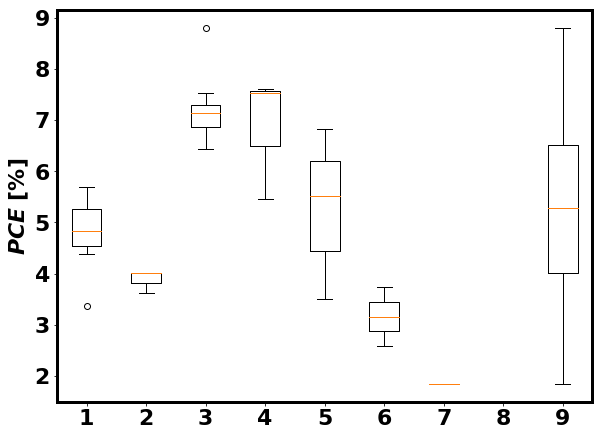

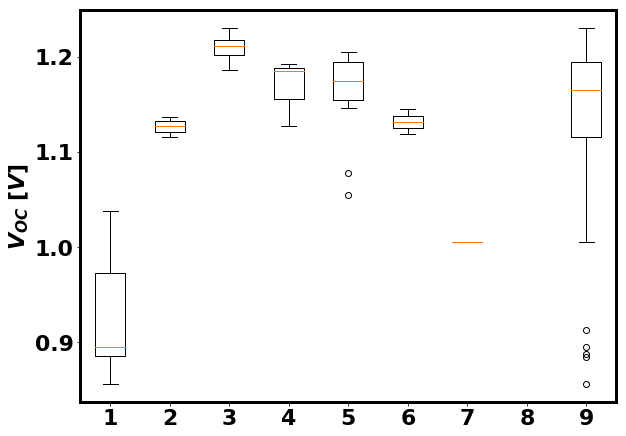

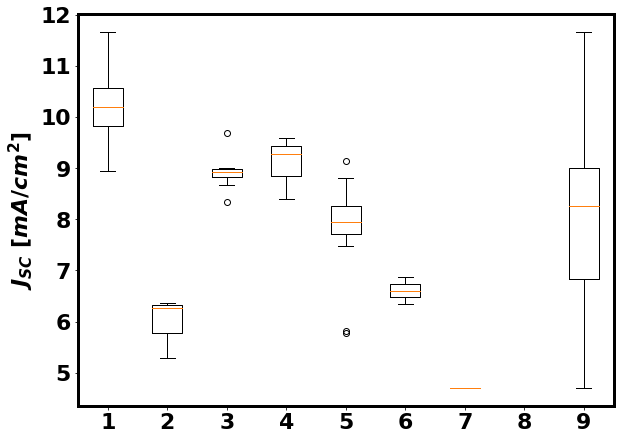

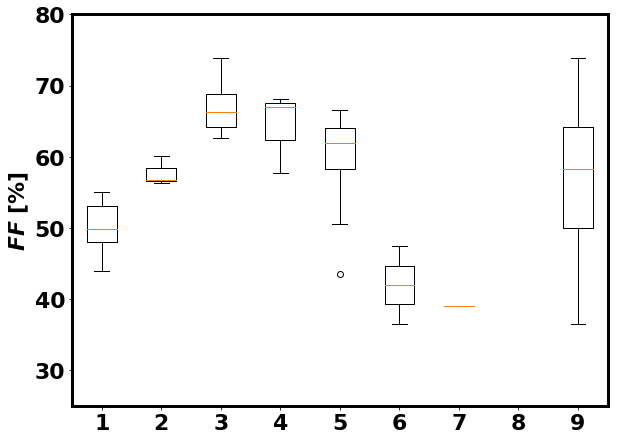

In [8]:
plt.boxplot(PCE_list);
plt.ylabel('$PCE\ [\%]$')
plt.figure()
plt.boxplot(Voc_list);
plt.ylabel('$V_{OC}\ [V]$')
#plt.ylim(.8,1.2)
plt.figure()
plt.boxplot(Jsc_list);
plt.ylabel('$J_{SC}\ [mA/cm^2]$')
plt.figure()
plt.boxplot(FF_list);
plt.ylabel('$FF\ [\%]$')
plt.ylim(25,80)

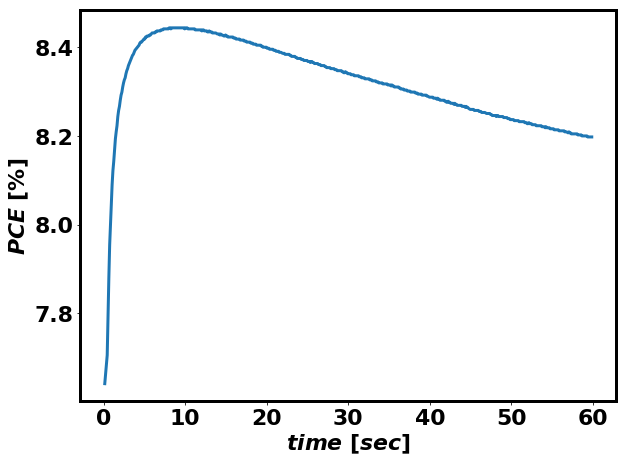

In [51]:
#Plot PCE with time
Directory = '2018_8-23JV/'
LName = '4_1_maxpp';


Ldata = np.loadtxt(Directory + LName)

Ldata = np.insert(Ldata, 3, -1000*Ldata[:,1]/CellAreacm, axis=1)

plt.plot(Ldata[:-2,0],Ldata[:-2,2]*Ldata[:-2,3],linewidth=3.0)
plt.ylabel('$PCE\ [\%]$')
plt.xlabel('$time\ [sec]$')

In [52]:
#make list of median Vocs and Jscs
med_data = np.zeros([9,2])
for ii in range(9):
    med_data[ii,0] = np.median(Voc_list[ii])
    med_data[ii,1] = np.median(Jsc_list[ii])

med_data[6,0] = 1.14
med_data[6,1] = 6.9

med_data[7,0] = 1.01
med_data[7,1] = 4.7

C:\Users\Ryan\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Ryan\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [53]:
med_data

array([[  0.89500026,  10.20052341],
       [  1.1271655 ,   6.26745936],
       [  1.21095721,   8.9254808 ],
       [  1.18458243,   9.27607824],
       [  1.17415652,   7.94849861],
       [  1.13174299,   6.60527246],
       [  1.14      ,   6.9       ],
       [  1.01      ,   4.7       ],
       [  1.16553693,   8.265023  ]])

In [54]:
np.savetxt('med_data.csv',med_data,delimiter=',')